# Ablauf

1) Daten einlesen
2) Daten aufbereiten
    -   Ausreißer identifizieren
3) GSMP-Kenndaten aufbereiten
4) Analyse
    

# 1. Daten einlesen

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

LOG_PATH = "shell-scripts/logs/start-stop-idle/"
LOG_NAME = "2024-02-05-12-40-00-baseworkers=0-count=90-STARTS"

#read first CSV
rawdata = pd.read_csv("CSV/2024-02-05_12-40-00 Pod_Process Power Consumption (W) in Namespace_ All-data-as-joinbyfield-2024-02-05 20_33_11.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read starting times
with open(LOG_PATH+LOG_NAME, "r") as file:
    start_times = file.readlines()

# remove newline-character, 
for i, time in enumerate(start_times):
    start_times[i] = time[:-1]


In [4]:
# remove irrelevant columns: 

columns_to_keep = rawdata.columns[~rawdata.columns.str.contains('measuring-endpoints|monitoring|console-worker|tasklist|operate|bpmndeployment|processstart|elasticsearch|connectors|load-controller')]
data = rawdata.loc[:, columns_to_keep]

data.columns

Index(['camunda-platform-zeebe-0 / camunda8 / PKG',
       'camunda-platform-zeebe-gateway-5ff76496c4-7hshw / camunda8 / PKG',
       'coredns-6799fbcd5-tqltp / kube-system / PKG',
       'helm-install-traefik-crd-j8d9v / kube-system / PKG',
       'helm-install-traefik-fv9zm / kube-system / PKG',
       'local-path-provisioner-84db5d44d9-666wr / kube-system / PKG',
       'metrics-server-67c658944b-tpg4k / kube-system / PKG',
       'svclb-traefik-80be9f52-nddwj / kube-system / PKG',
       'traefik-f4564c4f4-jj4hf / kube-system / PKG',
       'system_processes / system / PKG',
       ...
       'restworkerjava-56c6fcc879-vj2zm / worker / OTHER',
       'restworkerjava-56c6fcc879-vq2nt / worker / OTHER',
       'restworkerjava-56c6fcc879-x8db5 / worker / OTHER',
       'restworkerjava-56c6fcc879-xf7hs / worker / OTHER',
       'restworkerjava-56c6fcc879-xhftc / worker / OTHER',
       'restworkerjava-56c6fcc879-xnbbf / worker / OTHER',
       'restworkerjava-56c6fcc879-xvt88 / worker 

In [5]:
# rename 'kube-system' names to avoid double picking with 'system' namespace

new_columns = []
for i, col in enumerate(data.columns):
    if 'kube-system' in col:
        new_columns.append(col.replace('kube-system', 'kube'))
    else:
        new_columns.append(col)

data.columns = new_columns

In [6]:
# extract measurements. use list of start_times and measurements_per_cycle (amount of datapoints)
def split_data_into_cycles(df, start_times, measurements_per_cycle):
    cycles = []
    # Select all rows belonging to a cycle
    for item in start_times:
        temp = pd.DataFrame()

        index = df.index.get_loc(item) + 1

        temp = df.iloc[index:index + measurements_per_cycle,:]
        temp = temp.dropna(how="all", axis=1)

        cycles.append(temp)
    
    return cycles;

# every Cycle with 30 measurements is 1 entry in list
STEPS_PER_CYCLE = 30 # 5 Min * 6 Scrapes/Min

cycles = split_data_into_cycles(data, start_times,STEPS_PER_CYCLE)


In [7]:
# read namespaces from columns. 
# This relies on grafana CSV-outputs using '/' as a divider: "pod / namespace / domain"
def extract_namespaces(df):
    namespaces = []
    for col in df.columns:
        split_col = col.split('/')
        if len(split_col) > 1:
            namespace = split_col[1].strip()
            if namespace not in namespaces:
                namespaces.append(namespace)
    return namespaces;


In [8]:
# for each cycle, group all pods from namespace
def group_namespaces_per_cycle(cycles):
    grouped_cycles = []
    namespaces = extract_namespaces(data)

    for item in cycles:
        temp = pd.DataFrame()

        for namespace in namespaces:
            namespace_cols = [col for col in item.columns if namespace in col]
            temp[namespace] = item[namespace_cols].sum(axis=1)  

        grouped_cycles.append(temp)
    
    return grouped_cycles;


cycles_by_namespace = group_namespaces_per_cycle(cycles)

In [9]:
# create relative timestamps

def create_relative_timestamps(min, max, interval):
    elapsed_times = []
    for i in range(min,int(max/interval)):
        s = i * interval % 60
        m = int(i / (60 / interval))
        elapsed_times.append("{:02d}:{:02d}".format(m,s))

    return elapsed_times;

elapsed_times = create_relative_timestamps(0, 300, 10)

# elapsed_times


In [34]:
# create single dataframe for namespace for better readability
def isolate_namespace_per_cycle(namespace, cycles_list):
    df = pd.DataFrame(index=elapsed_times)
    
    for item in cycles_list:
        temp = item[namespace]
        temp.index = elapsed_times
        
        df[item.index[0]] = temp
    
    return df;

all_system_series = isolate_namespace_per_cycle("system", cycles_by_namespace)
all_worker_series = isolate_namespace_per_cycle("worker", cycles_by_namespace)


## Leerlauf-Stromverbrauch abziehen

Gewählte Methode: individuelle Betrachtung der 10-Sekunden-Intervalle

In [35]:
def remove_idle_power(df):
    idle_pattern = pd.Series()
        
    # create idle series in temp
    idle_base_pattern = df.iloc[24:, :].median(axis=1)

    for i in range(3):

        idle_base_pattern[i] = (idle_base_pattern[i] + idle_base_pattern[i + 3]) / 2

    idle_base_pattern = idle_base_pattern.drop(['04:30','04:40','04:50'])
    
    # repeat the base pattern until length of df.index is reached
    while len(idle_pattern) < len(df.index):
        idle_pattern = pd.concat([idle_pattern, idle_base_pattern])
    
    idle_pattern = idle_pattern.apply(pd.to_numeric, errors='coerce')
    idle_pattern.index = df.index

    temp = df.sub(idle_pattern, axis='index')

    return temp, idle_pattern



worker_no_idle , worker_idle_pattern = remove_idle_power(all_worker_series)
system_no_idle , system_idle_pattern = remove_idle_power(all_system_series)

    

camunda_no_idle = all_camunda_series
worker_no_idle = all_worker_series
kube_no_idle  = all_kube_system_series
system_no_idle = all_system_series

## Ausreißer löschen

In [36]:
def filter_outliers_iqr_per_row(row, multiplier=1.5):
    Q1 = row.quantile(0.25)
    Q3 = row.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = ((row < lower_bound) | (row > upper_bound))
    return row[~outliers]

# Function to apply the IQR method for each row in a DataFrame
def filter_outliers_iqr(df, multiplier=1.5):
    return df.apply(filter_outliers_iqr_per_row, axis=1).apply(pd.to_numeric, errors='coerce')


worker_clean = filter_outliers_iqr(worker_no_idle)

system_clean = filter_outliers_iqr(system_no_idle)

### Plotting

In [37]:
# create xlabels

xlabels = [f"{worker_clean.index[i]} - {worker_clean.index[i + 1]}" for i in range(len(worker_clean.index) - 1)]
xlabels.append("04:50 - 05:00")

xlabels

['00:00 - 00:10',
 '00:10 - 00:20',
 '00:20 - 00:30',
 '00:30 - 00:40',
 '00:40 - 00:50',
 '00:50 - 01:00',
 '01:00 - 01:10',
 '01:10 - 01:20',
 '01:20 - 01:30',
 '01:30 - 01:40',
 '01:40 - 01:50',
 '01:50 - 02:00',
 '02:00 - 02:10',
 '02:10 - 02:20',
 '02:20 - 02:30',
 '02:30 - 02:40',
 '02:40 - 02:50',
 '02:50 - 03:00',
 '03:00 - 03:10',
 '03:10 - 03:20',
 '03:20 - 03:30',
 '03:30 - 03:40',
 '03:40 - 03:50',
 '03:50 - 04:00',
 '04:00 - 04:10',
 '04:10 - 04:20',
 '04:20 - 04:30',
 '04:30 - 04:40',
 '04:40 - 04:50',
 '04:50 - 05:00']

In [39]:
# NAMING

power_axis = "Energieverbrauch [W]"
time_axis= "Zeit"

[Text(0, 0, '00:00 - 00:10'),
 Text(1, 0, '00:10 - 00:20'),
 Text(2, 0, '00:20 - 00:30'),
 Text(3, 0, '00:30 - 00:40'),
 Text(4, 0, '00:40 - 00:50'),
 Text(5, 0, '00:50 - 01:00'),
 Text(6, 0, '01:00 - 01:10'),
 Text(7, 0, '01:10 - 01:20'),
 Text(8, 0, '01:20 - 01:30'),
 Text(9, 0, '01:30 - 01:40'),
 Text(10, 0, '01:40 - 01:50'),
 Text(11, 0, '01:50 - 02:00'),
 Text(12, 0, '02:00 - 02:10'),
 Text(13, 0, '02:10 - 02:20'),
 Text(14, 0, '02:20 - 02:30'),
 Text(15, 0, '02:30 - 02:40'),
 Text(16, 0, '02:40 - 02:50'),
 Text(17, 0, '02:50 - 03:00'),
 Text(18, 0, '03:00 - 03:10'),
 Text(19, 0, '03:10 - 03:20'),
 Text(20, 0, '03:20 - 03:30'),
 Text(21, 0, '03:30 - 03:40'),
 Text(22, 0, '03:40 - 03:50'),
 Text(23, 0, '03:50 - 04:00'),
 Text(24, 0, '04:00 - 04:10'),
 Text(25, 0, '04:10 - 04:20'),
 Text(26, 0, '04:20 - 04:30'),
 Text(27, 0, '04:30 - 04:40'),
 Text(28, 0, '04:40 - 04:50'),
 Text(29, 0, '04:50 - 05:00')]

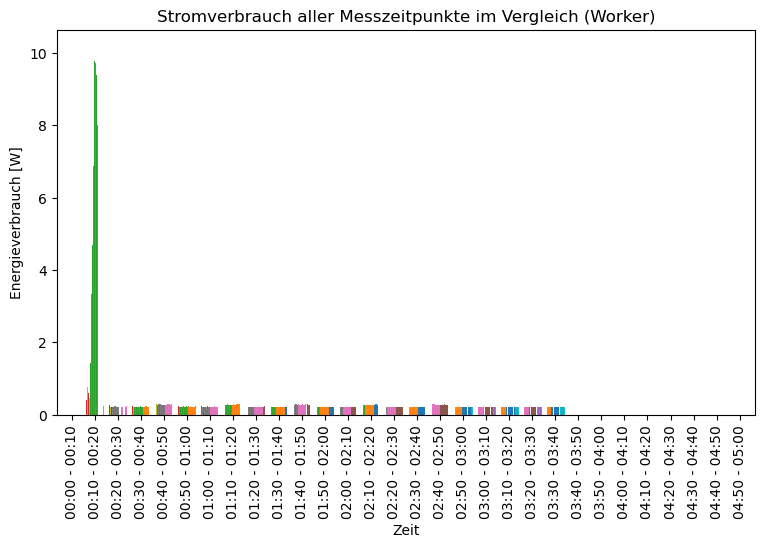

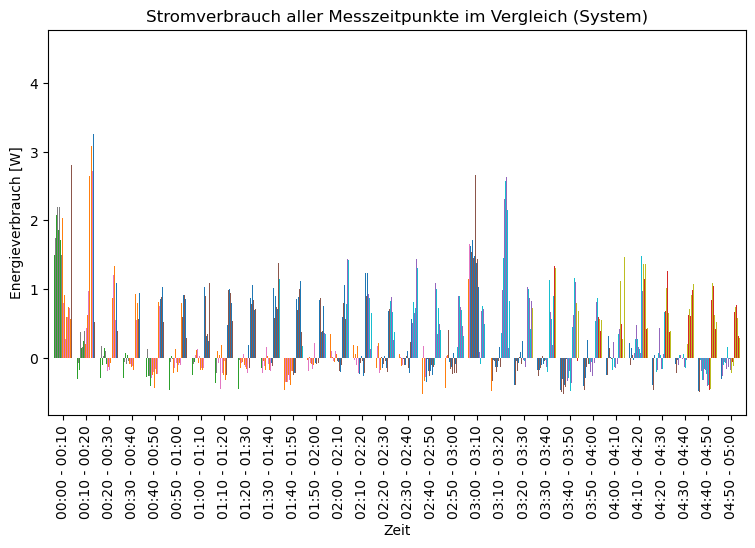

In [40]:
# plot results
ylim=[0,10]
xlim = [0,31] 
figsize = [9,5]
alpha=1
x_ticks = [0,6,12,18,24]
grid=False
width=0.8

ax = worker_clean.plot(width=width,
                kind='bar',
                legend=False,
                alpha = alpha,
                figsize = figsize,
                # xticks = x_ticks,
                grid = grid,
                title = "Stromverbrauch aller Messzeitpunkte im Vergleich (Worker)",
                xlabel=time_axis,
                ylabel=power_axis,
                xlim = xlim)
ax.set_xticklabels(xlabels)

ax = system_clean.plot(width=width,
                kind='bar',
                legend=False,
                alpha = alpha,
                figsize = figsize,
                # xticks = x_ticks,
                grid = grid,
                title = "Stromverbrauch aller Messzeitpunkte im Vergleich (System)",
                xlabel=time_axis,
                ylabel=power_axis,
                xlim = xlim)
ax.set_xticklabels(xlabels)



# camunda_no_idle_clean.plot(width=width, kind='bar', legend=False, alpha = alpha,  figsize = figsize, xticks = x_ticks, grid = grid, title = "Software Entity: Zeebe", xlabel='Time', ylabel='Consumed Power [W]', xlim = xlim)

[Text(1, 0, '00:00 - 00:10'),
 Text(2, 0, '00:10 - 00:20'),
 Text(3, 0, '00:20 - 00:30'),
 Text(4, 0, '00:30 - 00:40'),
 Text(5, 0, '00:40 - 00:50'),
 Text(6, 0, '00:50 - 01:00'),
 Text(7, 0, '01:00 - 01:10'),
 Text(8, 0, '01:10 - 01:20'),
 Text(9, 0, '01:20 - 01:30'),
 Text(10, 0, '01:30 - 01:40'),
 Text(11, 0, '01:40 - 01:50'),
 Text(12, 0, '01:50 - 02:00'),
 Text(13, 0, '02:00 - 02:10'),
 Text(14, 0, '02:10 - 02:20'),
 Text(15, 0, '02:20 - 02:30'),
 Text(16, 0, '02:30 - 02:40'),
 Text(17, 0, '02:40 - 02:50'),
 Text(18, 0, '02:50 - 03:00'),
 Text(19, 0, '03:00 - 03:10'),
 Text(20, 0, '03:10 - 03:20'),
 Text(21, 0, '03:20 - 03:30'),
 Text(22, 0, '03:30 - 03:40'),
 Text(23, 0, '03:40 - 03:50'),
 Text(24, 0, '03:50 - 04:00'),
 Text(25, 0, '04:00 - 04:10'),
 Text(26, 0, '04:10 - 04:20'),
 Text(27, 0, '04:20 - 04:30'),
 Text(28, 0, '04:30 - 04:40'),
 Text(29, 0, '04:40 - 04:50'),
 Text(30, 0, '04:50 - 05:00')]

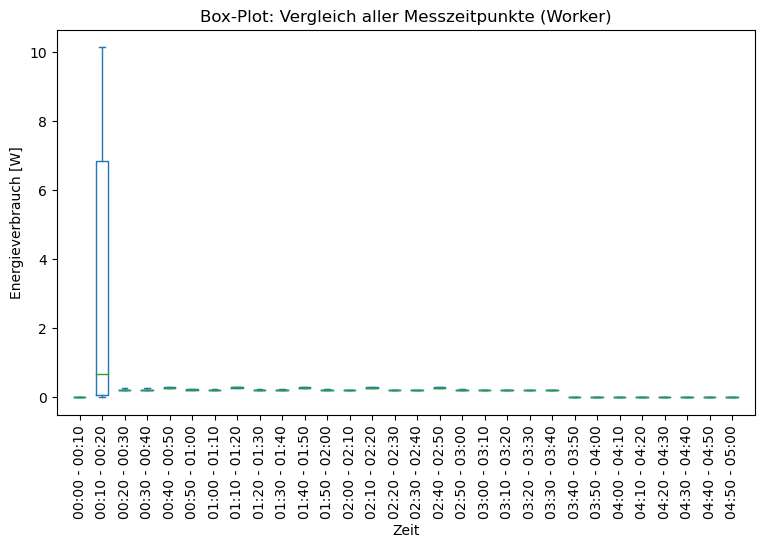

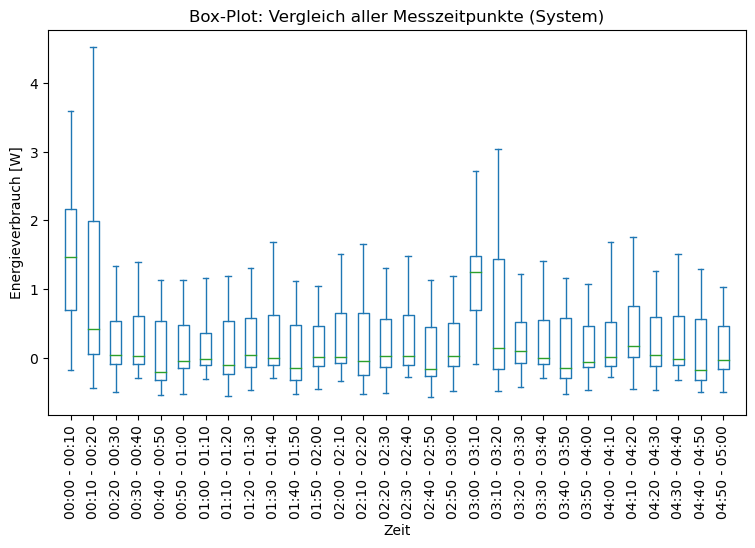

In [41]:
whis = [0,100]

worker_clean_T = worker_clean.T

ax = worker_clean_T.plot(legend=False, 
                     kind='box', 
                     rot=90, 
                     whis= whis, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Box-Plot: Vergleich aller Messzeitpunkte (Worker)", 
                     xlabel=time_axis, 
                     ylabel=power_axis)
ax.set_xticklabels(xlabels)

system_clean_T = system_clean.T

ax = system_clean_T.plot(legend=False, 
                     kind='box', 
                     rot=90, 
                     whis= whis, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Box-Plot: Vergleich aller Messzeitpunkte (System)", 
                     xlabel=time_axis, 
                     ylabel=power_axis)
ax.set_xticklabels(xlabels)

[Text(0, 0, '00:00 - 00:10'),
 Text(1, 0, '00:10 - 00:20'),
 Text(2, 0, '00:20 - 00:30'),
 Text(3, 0, '00:30 - 00:40'),
 Text(4, 0, '00:40 - 00:50'),
 Text(5, 0, '00:50 - 01:00'),
 Text(6, 0, '01:00 - 01:10'),
 Text(7, 0, '01:10 - 01:20'),
 Text(8, 0, '01:20 - 01:30'),
 Text(9, 0, '01:30 - 01:40'),
 Text(10, 0, '01:40 - 01:50'),
 Text(11, 0, '01:50 - 02:00'),
 Text(12, 0, '02:00 - 02:10'),
 Text(13, 0, '02:10 - 02:20'),
 Text(14, 0, '02:20 - 02:30'),
 Text(15, 0, '02:30 - 02:40'),
 Text(16, 0, '02:40 - 02:50'),
 Text(17, 0, '02:50 - 03:00'),
 Text(18, 0, '03:00 - 03:10'),
 Text(19, 0, '03:10 - 03:20'),
 Text(20, 0, '03:20 - 03:30'),
 Text(21, 0, '03:30 - 03:40'),
 Text(22, 0, '03:40 - 03:50'),
 Text(23, 0, '03:50 - 04:00'),
 Text(24, 0, '04:00 - 04:10'),
 Text(25, 0, '04:10 - 04:20'),
 Text(26, 0, '04:20 - 04:30'),
 Text(27, 0, '04:30 - 04:40'),
 Text(28, 0, '04:40 - 04:50'),
 Text(29, 0, '04:50 - 05:00')]

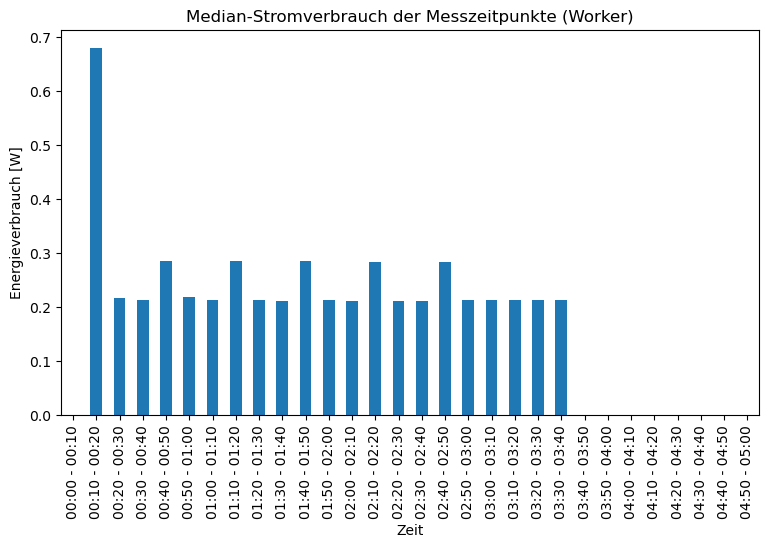

In [50]:
ax = worker_clean.median(axis='columns').plot(legend=False, 
                     kind='bar', 
                     rot=90, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Median-Stromverbrauch der Messzeitpunkte (Worker)", 
                     xlabel=time_axis, 
                     ylabel=power_axis)
ax.set_xticklabels(xlabels)

[Text(0, 0, '00:00 - 00:10'),
 Text(1, 0, '00:10 - 00:20'),
 Text(2, 0, '00:20 - 00:30'),
 Text(3, 0, '00:30 - 00:40'),
 Text(4, 0, '00:40 - 00:50'),
 Text(5, 0, '00:50 - 01:00'),
 Text(6, 0, '01:00 - 01:10'),
 Text(7, 0, '01:10 - 01:20'),
 Text(8, 0, '01:20 - 01:30'),
 Text(9, 0, '01:30 - 01:40'),
 Text(10, 0, '01:40 - 01:50'),
 Text(11, 0, '01:50 - 02:00'),
 Text(12, 0, '02:00 - 02:10'),
 Text(13, 0, '02:10 - 02:20'),
 Text(14, 0, '02:20 - 02:30'),
 Text(15, 0, '02:30 - 02:40'),
 Text(16, 0, '02:40 - 02:50'),
 Text(17, 0, '02:50 - 03:00'),
 Text(18, 0, '03:00 - 03:10'),
 Text(19, 0, '03:10 - 03:20'),
 Text(20, 0, '03:20 - 03:30'),
 Text(21, 0, '03:30 - 03:40'),
 Text(22, 0, '03:40 - 03:50'),
 Text(23, 0, '03:50 - 04:00'),
 Text(24, 0, '04:00 - 04:10'),
 Text(25, 0, '04:10 - 04:20'),
 Text(26, 0, '04:20 - 04:30'),
 Text(27, 0, '04:30 - 04:40'),
 Text(28, 0, '04:40 - 04:50'),
 Text(29, 0, '04:50 - 05:00')]

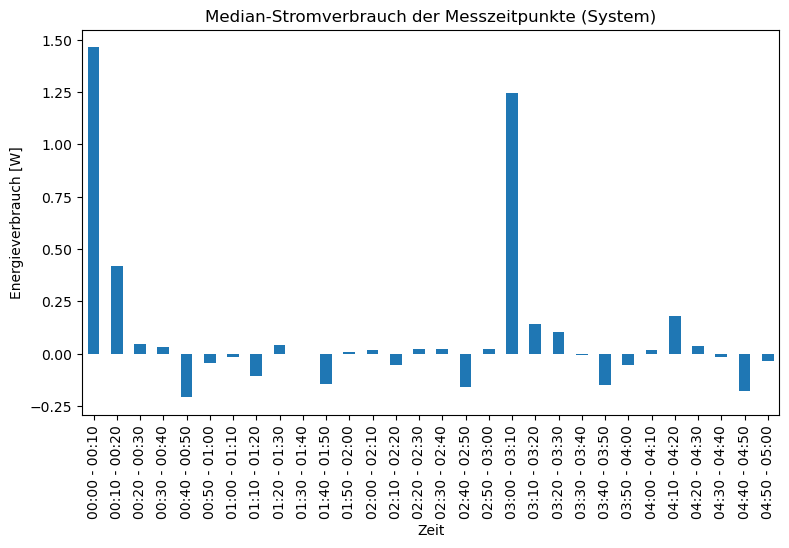

In [51]:
ax = system_clean.median(axis='columns').plot(legend=False, 
                     kind='bar', 
                     rot=90, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Median-Stromverbrauch der Messzeitpunkte (System)", 
                     xlabel=time_axis, 
                     ylabel=power_axis)
ax.set_xticklabels(xlabels)

#### Start

In [52]:
start_interval_begin = 0
start_interval_end = 2

start = pd.Series()
start['Event-Duration'] = '20 Sec'


# create medians for all intervals.
# medians are inaverage  Ws / s for 10 Seconds. 
# Values should be multiplied by 10 to reflect amount of actually consumed Ws

start['Median Usage Worker'] = worker_clean.median(axis='columns')[start_interval_begin:start_interval_end].sum() * 10
start['Median Usage System'] = system_clean.median(axis='columns')[start_interval_begin:start_interval_end].sum() * 10
start['Median Sum'] = start['Median Usage System'] + start['Median Usage Worker']



#### Worker-Leerlauf

In [56]:
idle_worker_per_min = pd.Series()
idle_worker_per_min['Event-Duration'] = '1 Min.'
idle_worker_per_min['Median Usage Worker'] = worker_clean.median(axis='columns')[2:18].sum() / (16/6) * 10
idle_worker_per_min['Median Usage System'] = system_clean.median(axis='columns')[2:18].sum() / (16/6) * 10
idle_worker_per_min['Median Sum'] = idle_worker_per_min['Median Usage System'] + idle_worker_per_min['Median Usage Worker']

#### Stopping

In [57]:
stop_interval_begin = 18
stop_interval_end = 21

stop = pd.Series()
stop['Event-Duration'] = '30 sec'
stop['Median Usage Worker'] = worker_clean.median(axis='columns')[stop_interval_begin:stop_interval_end].sum() * 10
stop['Median Usage System'] = system_clean.median(axis='columns')[stop_interval_begin:stop_interval_end].sum() * 10
stop['Median Sum'] = stop['Median Usage System'] + stop['Median Usage Worker']

In [58]:
phases = pd.DataFrame()

phases['start'] = start
phases['stop'] = stop   
phases['idle worker'] = idle_worker_per_min

phases

,start,stop,idle worker
Event-Duration,20 Sec,30 sec,1 Min.
Median Usage Worker,6.7875,6.3765,14.105813
Median Usage System,18.840563,14.950438,-1.995914
Median Sum,25.628062,21.326938,12.109898


In [59]:
total_cost_scaling = phases.loc['Median Sum','start'] + phases.loc['Median Sum','stop']

time_ratio_scaling = total_cost_scaling / phases.loc['Median Sum', 'idle worker']

print(total_cost_scaling, time_ratio_scaling)

46.955 3.8774065895216134


### Start

1) Berechne Median der 10s-Intervalle in Min 2,3
2) Berechne Unterschied jedes 10s Intervalls in Min 1 zu Median(Min2,3)
3) Ab welchem Unterschied wird das Min1 Intervall zur Baseline gezählt?
    -> initaler gRPC-Call bei Zeebe?

In [31]:
# create array for all indicators
namespace_indicators = []

#set limits of phases (index of datapoint)
worker_start_lim = [0, 3]
idle_worker_lim = [3, 18] # min2,3
worker_stop_lim = [18, 22] #min4
idle_system = [22, 30] # min5


# go through each cycle and calculate:
# min2+3    median
# min5      median

def generate_indicators(all_namespace_series):
   temp = pd.DataFrame()

   temp.loc['start', 'median'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().median()
   temp.loc['idle_worker', 'median'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().median()
   temp.loc['stop', 'median'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().median()
   temp.loc['idle_system', 'median'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().median()
   
   temp.loc['start', 'mean'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().mean()
   temp.loc['idle_worker', 'mean'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().mean()
   temp.loc['stop', 'mean'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().mean()
   temp.loc['idle_system', 'mean'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().mean()

   temp.loc['start', 'min'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].min(axis=0).min()
   temp.loc['idle_worker', 'min'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].min(axis=0).min()
   temp.loc['stop', 'min'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].min(axis=0).min()
   temp.loc['idle_system', 'min'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].min(axis=0).min()

   temp.loc['start', 'max'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].max(axis=0).max()
   temp.loc['idle_worker', 'max'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].max(axis=0).max()
   temp.loc['stop', 'max'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].max(axis=0).max()
   temp.loc['idle_system', 'max'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].max(axis=0).max()

   temp['span'] = temp['max'] - temp['min']

   temp.loc['start', 'std'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().std()
   temp.loc['idle_worker', 'std'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().std()
   temp.loc['stop', 'std'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().std()
   temp.loc['idle_system', 'std'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().std()

   temp.loc['start', 'variance'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().var()
   temp.loc['idle_worker', 'variance'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().var()
   temp.loc['stop', 'variance'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().var()
   temp.loc['idle_system', 'variance'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().var()

   temp.loc['start', 'IQR'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().quantile(0.75) - all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().quantile(0.25)
   temp.loc['idle_worker', 'IQR'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().quantile(0.75) - all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().quantile(0.25)
   temp.loc['stop', 'IQR'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().quantile(0.75) - all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().quantile(0.25)
   temp.loc['idle_system', 'IQR'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().quantile(0.75) - all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().quantile(0.25)

   # add trimmed mean, winsorized mean, mae

   return temp;

camunda_indicator = generate_indicators(all_camunda_series)

camunda_indicator


,median,mean,min,max,span,std,variance,IQR
start,0.60995,0.655586,0.4720,1.1954,0.7234,0.126632,0.016036,0.190725
idle_worker,0.57835,0.598134,0.4366,1.1435,0.7069,0.102237,0.010452,0.134600
stop,0.57905,0.614853,0.4647,1.4591,0.9944,0.121464,0.014753,0.151875
idle_system,0.59205,0.616857,0.4494,1.1000,0.6506,0.104497,0.010920,0.148300


In [32]:
def generate_indicators_by_time(all_namespace_series):
    temp = pd.DataFrame()

    temp['mean'] = all_namespace_series.mean(axis=1)
    temp['median'] = all_namespace_series.median(axis=1)
    temp['min'] = all_namespace_series.min(axis=1)
    temp['max'] = all_namespace_series.max(axis=1)
    temp['span'] = temp['max'] -temp['min']
    temp['std'] = all_namespace_series.std(axis=1)
    temp['var'] = all_namespace_series.var(axis=1)
    temp['IQR'] = all_namespace_series.quantile(0.75,axis=1) - all_namespace_series.quantile(0.25, axis=1)


    return temp

#camunda_time_indicator = generate_indicators_by_time(camunda_clean)

#camunda_time_indicator.plot()

In [33]:
def extract_phase_indicators(all_namespace_series):
   temp = pd.DataFrame()

   temp['start'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack()
   temp['idle_worker'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack()
   temp['stop'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack()
   temp['idle_system'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack()

   # add trimmed mean, winsorized mean, mae

   return temp;


#camunda_phases = extract_phase_indicators(camunda_clean)

camunda_phases

NameError: name 'camunda_phases' is not defined

In [ ]:
def create_phase_column(df, limits=[0,1,17,20,29],names=["start", "idle_worker","stop", "idle_system"]):
    current_group = 0
    buckets= []
    
    for i in range(len(df.index)):
        buckets.append(names[current_group])
        if i == limits[current_group +1]:
            current_group = current_group+1
    
    df['bucket'] = buckets
    return df

#camunda_clean_phases = create_phase_column(camunda_clean)



<Axes: >

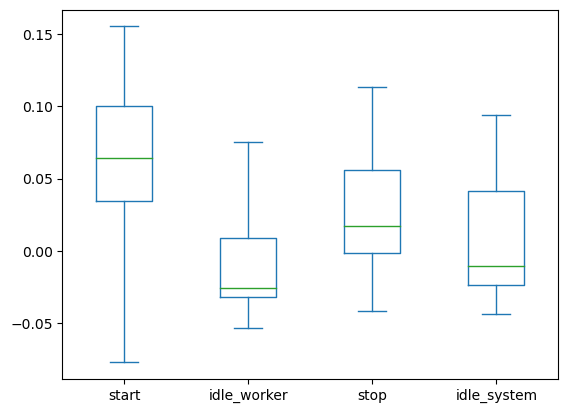

In [ ]:
def extract_phases(df):
    bucket_sizes = df['bucket'].value_counts()

    # create power sum
    start = df[df['bucket'] == 'start'].sum(axis=0).drop('bucket')
    idle_worker = df[df['bucket'] == 'idle_worker'].sum(axis=0).drop('bucket')
    stop = df[df['bucket'] == 'stop'].sum(axis=0).drop('bucket')
    idle_system = df[df['bucket'] == 'idle_system'].sum(axis=0).drop('bucket')

    # divide by amount of 30 second segments
    start = start / bucket_sizes['start']
    idle_worker = idle_worker / bucket_sizes['idle_worker']
    stop = stop / bucket_sizes['stop']
    idle_system = idle_system / bucket_sizes['idle_system']

    temp = pd.concat([start, idle_worker, stop, idle_system], axis=1, keys=['start', 'idle_worker', 'stop','idle_system']).apply(pd.to_numeric, errors='coerce')
    
    return temp

#camunda_phases = extract_phases(camunda_clean_phases)

camunda_phases.plot(kind='box', whis=[0,100])

### Stop

1) Zeitfenster stoppen: Min4  Beginn bis letzter Wert Worker